## Importing libraries

In [ ]:
!pip install pydub
import os
import tensorflow as tf
import cv2
from numpy import array
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.models import Model
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from keras.initializers import glorot_uniform
import numpy as np
import pandas as pd
from IPython.display import Audio
from scipy.io.wavfile import read, write
import os
import wave
from IPython.display import Audio
from scipy.io.wavfile import read, write
import tarfile
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras.utils import to_categorical
import scipy.signal
import pydub
from PIL import Image
from keras.layers import Input, concatenate 
from keras.optimizers import SGD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Get data

In [ ]:
"""
Get data from tanserflow to colab project and Extract all contents of the tar file to the current working directory
"""
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz

with tarfile.open("/content/speech_commands_v0.01.tar.gz", "r:gz") as tar:
    tar.extractall()

--2023-02-25 00:37:03--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.194.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  38.1MB/s    in 52s     

2023-02-25 00:37:57 (27.4 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



# Loading data

In [ ]:
def blender(label, data, rate, noisy):
  """
  Randomly shuffles the input arrays and returns them in the shuffled order.

    Parameters:
        label (ndarray): A 1-dimensional array of labels for the data.
        data (ndarray): A 2-dimensional array of data.
        rate (ndarray): A 1-dimensional array of rates.
        noisy (ndarray): A 1-dimensional array of noise values.

    Returns:
        Tuple[ndarray, ndarray, ndarray, ndarray]: A tuple containing the shuffled label, data, rate, and noisy arrays.

    Raises:
        ValueError: If the input arrays are not of the same length.

    Example:
        >>> label = np.array([1, 2, 3, 4, 5])
        >>> data = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
        >>> rate = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
        >>> noisy = np.array([0.01, 0.02, 0.03, 0.04, 0.05])
        >>> blended_label, blended_data, blended_rate, blended_noisy = blender(label, data, rate, noisy)
        >>> print(blended_label)
        [4 3 2 1 5]
        >>> print(blended_data)
        [[7 8]
         [5 6]
         [3 4]
         [1 2]
         [9 10]]
        >>> print(blended_rate)
        [0.4 0.3 0.2 0.1 0.5]
        >>> print(blended_noisy)
        [0.04 0.03 0.02 0.01 0.05]
  """
  idx = np.random.permutation(data.shape[0])
  return label[idx], data[idx], rate[idx], noisy[idx]

def resize_to_comp(data):
  """
    Resizes an image represented as a 2-dimensional numpy array by adding 3 pixels to the width and height.

    Parameters:
        data (ndarray): A 2-dimensional numpy array representing an image.

    Returns:
        ndarray: A 2-dimensional numpy array representing the resized image.

    Example:
        >>> data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
        >>> resized_data = resize_to_comp(data)
        >>> print(resized_data)
        [[0 0 0 0 0 0]
         [0 1 2 3 0 0]
         [0 4 5 6 0 0]
         [0 7 8 9 0 0]
         [0 0 0 0 0 0]
         [0 0 0 0 0 0]]
  """
  image = Image.fromarray(data)
  new_shape = (image.width + 3, image.height + 3)
  resized_image = image.resize(new_shape)
  x_train_resized = np.asarray(resized_image)
  return x_train_resized

def to_spictro(audio, fs=16000):
  """
    Converts an audio signal to its spectrogram representation.

    Parameters:
        audio (ndarray): A 1-dimensional numpy array representing the audio signal.
        fs (int): Sampling rate of the audio signal. Defaults to 16000 Hz.

    Returns:
        ndarray: A 2-dimensional numpy array representing the spectrogram of the audio signal.

    Example:
        >>> audio = np.random.randn(16000)
        >>> spectrogram = to_spectro(audio)
        >>> print(spectrogram.shape)
        (130, 130)
  """
  #fs, audio = read(audio)
  f, t, Zxx = scipy.signal.stft(audio, fs, nperseg=1024)
  spectro = np.abs(Zxx)
  spectro = resize_to_comp(spectro)
  return spectro
  
def data_load(list_of_classes, number_of_samples, effect):
  """
  Loads audio data for specified classes and prepares it for training a machine learning model.

    Parameters:
        list_of_classes (List[str]): A list of strings representing the names of the classes to be loaded.
        number_of_samples (int): The number of samples to be loaded for each class.
        effect (float): The level of noise to add to each audio sample as a float value between 0 and 1.

    Returns:
        Tuple[ndarray, ndarray, ndarray, ndarray]: A tuple of four numpy arrays representing the labels, spectrograms of the
        audio signals, sampling rates, and spectrograms of the noisy audio signals, respectively.

    Example:
        >>> list_of_classes = ['class1', 'class2']
        >>> number_of_samples = 10
        >>> effect = 0.1
        >>> y, x, r, n = data_load(list_of_classes, number_of_samples, effect)
        >>> print(y.shape, x.shape, r.shape, n.shape)
        (20,), (20, 130, 130), (20,), (20, 130, 130)
  """
  y, x, r, n= [], [], [], []
  for i in range(len(list_of_classes)):
    audios = os.listdir('/content/' + list_of_classes[i])
    j = 0
    temp1 = 0
    while temp1 < number_of_samples:  
      fs, audio = read('/content/'+list_of_classes[i]+'/'+audios[j])
      f, t, Zxx = scipy.signal.stft(audio, fs, nperseg=1024)
      spectro = to_spictro(audio)
      temp = audio.shape[0]
      if temp == 16000:
        y.append(i)
        x.append(spectro)
        r.append(fs)
        noise = np.random.normal(0, 1, audio.shape)
        noisy = audio + noise * effect
        f2, t2, Zxx2 = scipy.signal.stft(noisy, fs, nperseg=1024)
        spectronoisy = np.abs(Zxx2)
        spectronoisy = to_spictro(noisy)
        n.append(spectronoisy)
        temp1 += 1
      j += 1
    print(f"{len(y)} of data is loaded !\n")
  return blender(np.array(y), np.array(x), np.array(r), np.array(n))

In [ ]:
y, x, r, n = data_load(['one', 'two', 'three'], 1500, 3000)

1500 of data is loaded !

3000 of data is loaded !

4500 of data is loaded !



In [ ]:
def show_spectro(spictro, classes=[], label=None):
  """
  Plots a spectrogram of an audio signal using matplotlib.

    Parameters:
        spictro (ndarray): A numpy array representing the spectrogram of an audio signal.
        classes (List[str]): A list of strings representing the names of the classes, one for each spectrogram.
        label (int): The index of the class to which the spectrogram belongs.

    Returns:
        None

    Example:
        >>> spictro = np.random.rand(130, 130)
        >>> show_spectro(spictro)
  """
  plt.figure(figsize=(20, 5))
  ax = plt.subplot(1, 1, 1)
  plt.imshow(spictro, aspect=float(50/1000), cmap='plasma')
  if label != None:
    plt.title(classes[label] + '/ class ' + str(label))
  plt.colorbar()
  plt.axis('off')
  plt.savefig("spectro_noisy.png", transparent=True)
  plt.show()

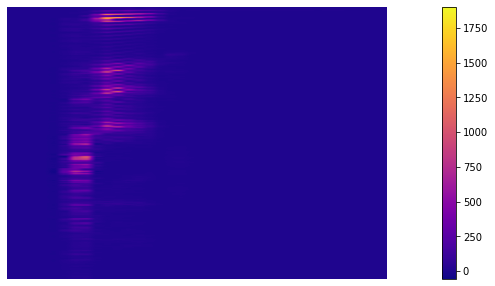

In [ ]:
show_spectro(x[10])

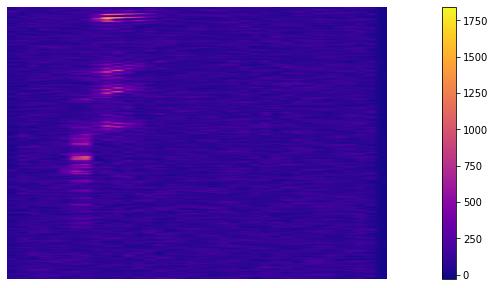

In [ ]:
show_spectro(n[10])

#CNN model

##Data pre-processing

In [ ]:
def data_preprocessing(data, labels, num_classes):
  """
  Performs data preprocessing on audio spectrograms and their corresponding labels.

    Parameters:
        data (ndarray): A numpy array containing the audio spectrograms.
        labels (ndarray): A numpy array containing the corresponding labels for each audio spectrogram.
        num_classes (int): An integer representing the number of classes in the dataset.

    Returns:
        A tuple containing the preprocessed training and testing data and their corresponding labels.

    Example:
        >>> x = np.random.rand(100, 128, 128)
        >>> y = np.random.randint(0, 2, 100)
        >>> y_train, y_test, x_train, x_test = data_preprocessing(x, y, 2)
  """
  x_train, x_test = np.split(data, [int(0.8 * len(data))])
  y_train, y_test = np.split(labels, [int(0.8 * len(labels))])

  x_train = x_train / 255
  x_test = x_test / 255

  y_train = to_categorical(y_train, num_classes)
  y_test = to_categorical(y_test, num_classes)
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
  x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32') 
  return y_train, y_test, x_train, x_test

In [ ]:
y_train, y_test, x_train, x_test = data_preprocessing(x, y, 3)

## classification model

In [ ]:
def define_model(input_size = (516, 36, 1), numclasses=3):
  """
  Returns a Keras model for a convolutional neural network with the specified architecture.

    Parameters:
        input_size (tuple): The input shape of the model as a tuple of integers. Default is (516, 36, 1).
        numclasses (int): The number of output classes for the model. Default is 3.

    Returns:
        A Keras model instance.
  """
  inputs = Input(input_size)
  conv1 = Conv2D(128, (7,2), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(128, (7,2), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  

  conv3 = Conv2D(64, (7,2), activation='relu', padding='same')(pool1)
  conv3 = Conv2D(64, (7,2), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  
  conv4 = Conv2D(32, (7,2), activation='relu', padding='same')(pool3)
  
  fltt = Flatten()(conv4)
  
  dan = Dense(numclasses, activation='softmax')(fltt)
  
  model = Model(inputs=inputs, outputs=dan)
  
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  
  
  return model

In [ ]:
model = define_model(x_train[0].shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 519, 39, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 519, 39, 128)      1920      
                                                                 
 conv2d_1 (Conv2D)           (None, 519, 39, 128)      229504    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 259, 19, 128)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 259, 19, 64)       114752    
                                                                 
 conv2d_3 (Conv2D)           (None, 259, 19, 64)       57408     
                                                             

In [ ]:
"""
train the modul
"""
his = model.fit(x_train, y_train, epochs=7, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/7
57/57 [==============================] - 54s 644ms/step - loss: 0.5640 - accuracy: 0.7883 - val_loss: 0.3713 - val_accuracy: 0.8856
Epoch 2/7
57/57 [==============================] - 33s 582ms/step - loss: 0.2386 - accuracy: 0.9203 - val_loss: 0.1844 - val_accuracy: 0.9500
Epoch 3/7
57/57 [==============================] - 33s 582ms/step - loss: 0.1399 - accuracy: 0.9539 - val_loss: 0.1426 - val_accuracy: 0.9678
Epoch 4/7
57/57 [==============================] - 33s 586ms/step - loss: 0.0914 - accuracy: 0.9672 - val_loss: 0.1275 - val_accuracy: 0.9667
Epoch 5/7
57/57 [==============================] - 33s 582ms/step - loss: 0.0717 - accuracy: 0.9728 - val_loss: 0.1373 - val_accuracy: 0.9600
Epoch 6/7
57/57 [==============================] - 34s 596ms/step - loss: 0.1012 - accuracy: 0.9650 - val_loss: 0.2039 - val_accuracy: 0.9611
Epoch 7/7
57/57 [==============================] - 33s 578ms/step - loss: 0.0872 - accuracy: 0.9672 - val_loss: 0.1453 - val_accuracy: 0.9622


In [ ]:
def save_model(model):
  """
  Function: save_model

  Saves a Keras model as a JSON file and its weights as an H5 file.

  Arguments:
  - model: A Keras model object to be saved.

  Returns:
  None.

  Example:
  save_model(model)

  This will save the Keras model to the current directory as two files: 'model.json' and 'model.h5'.

  The 'model.json' file contains the architecture of the model in JSON format, while the 'model.h5' file contains the weights of the model.

  Note: The saved model can be loaded back into memory using the Keras load_model() function.
  """
  model_architecture = model.to_json()
  with open('model.json', 'w') as json_file:
      json_file.write(model_architecture)
  model.save_weights('model.h5')
  print("model saved under name: 'model.json' and 'model.h5'")

In [ ]:
save_model(model)

model saved under name: 'model.json' and 'model.h5'


In [ ]:
def plot_history_acc(hist):
  """
  Plot the accuracy values recorded during the training of a neural network.

    Args:
        hist (History): The training history object, as returned by the `fit` method of a Keras model.

    Returns:
        None
  """
  plt.grid(True, which='both')
  plt.plot(hist.history['accuracy'], color='gold')
  plt.plot(hist.history['val_accuracy'], color='purple')
  plt.title('CNN model accuracy')
  plt.legend(['acc', 'val_acc'])
  plt.savefig("CNN_acc.png", transparent=True)
  plt.show()

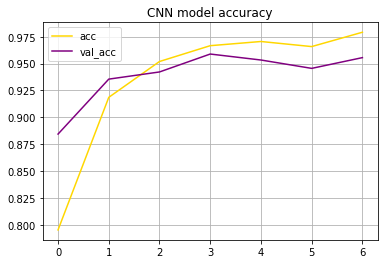

In [ ]:
plot_history_acc(his)

In [ ]:
def plot_history_loss(hist):
  """
  Plots the training and validation loss history of a Keras model.

  Parameters:

  hist: A History object returned by model.fit(). The History object contains information about the training history of the model.
  Returns:

  None
  """
  plt.grid(True, which='both')
  plt.plot(hist.history['loss'], color='gold')
  plt.plot(hist.history['val_loss'], color='purple')
  plt.title('CNN model loss')
  plt.legend(['loss', 'val_loss'])
  plt.savefig("CNN_loss.png", transparent=True)
  plt.show()

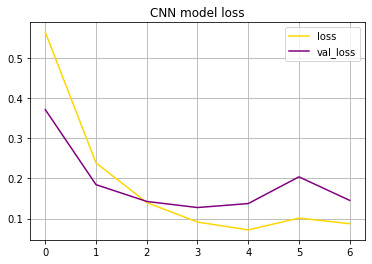

In [ ]:
plot_history_loss(his)

### Apply Effect on the model

In [ ]:
def test_effect(classes=['one','two','three'], c_model=None, g_model=None):
  """
  Function Name:
  test_effect

  Input:

  classes: a list of strings, default value ['one','two','three'], containing the names of the classes.
  c_model: a Keras model object, default value None, which is the classifier model to be tested.
  g_model: a Keras model object, default value None, which is an optional generative model that generates noise to be added to the input.
  Output:
  This function does not return anything but generates a plot of the effects of noise on the accuracy of the classifier model.

  Functionality:
  This function tests the effect of noise on the accuracy of a classifier model. It takes in a list of class names, a classifier model, and an optional generative model. The function then generates noise and adds it to the input data. It evaluates the accuracy of the classifier model on the noisy input data and records the accuracy and the amount of noise added. It then generates a plot of the accuracy versus the amount of noise added, with a separate line for the accuracy when using the generative model to add noise. The plot also includes annotations of the accuracy values at each noise level.
  Example:
    # Create and compile a classifier model
    c_model = tf.keras.Sequential([...])
    c_model.compile(...)

    # Create and compile a generative model
    g_model = tf.keras.Sequential([...])
    g_model.compile(...)

    # Test the effect of noise on the classifier model
    test_effect(['cat', 'dog'], c_model, g_model)
  """
  loss = []
  acc = []
  eff = []
  acc2 = []
  for i in [1000, 2000, 3000, 4000, 5000]:
    y, x, _, n = data_load(classes, 200, i)
    x = x / 255
    n = n / 255
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1).astype('float32')
    n = n.reshape(n.shape[0], n.shape[1], n.shape[2], 1).astype('float32')
    y = to_categorical(y, len(classes))
    test_loss, test_acc = c_model.evaluate(n, y)
    loss.append(test_loss)
    acc.append(test_acc)
    eff.append(i)
    if g_model != None:
      test_loss2, test_acc2 = c_model.evaluate(g_model.predict(n), y)
      acc2.append(test_acc2)
    print("succ of ", i)
  
  x = np.arange(14)
  y = np.sin(x / 2)

  if g_model != None:
    plt.step(acc2, eff, label='Auto noisy acc', color="purple")
    plt.plot(acc2, eff, 'o--', color='grey', alpha=0.3)

  plt.step(acc, eff, where='mid', label='Noisy acc', color="gold")
  plt.plot(acc, eff, 'o--', color='grey', alpha=0.4)

  l = []
  for ac in acc:
    t = str(int(ac * 100)) + "%"
    l.append(t)

  for i, txt in enumerate(l):
      plt.annotate(txt, (acc[i], eff[i]), color='grey')
  
  if g_model != None:
    l = []
    for ac2 in acc2:
      t = str(int(ac2 * 100)) + "%"
      l.append(t)

    for i, txt in enumerate(l):
        plt.annotate(txt, (acc2[i], eff[i]), color='grey')

  plt.grid(axis='x', color='0.95')
  plt.legend(title='Parameter where:')
  plt.title('Noise effect on CNN model')
  plt.savefig("noisy_effect.png", transparent=True)
  plt.show()

200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 3s 116ms/step - loss: 0.5182 - accuracy: 0.7983
succ of  1000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 67ms/step - loss: 1.0551 - accuracy: 0.6733
succ of  2000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 68ms/step - loss: 1.4339 - accuracy: 0.6017
succ of  3000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 67ms/step - loss: 1.6975 - accuracy: 0.5450
succ of  4000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 70ms/step - loss: 2.1001 - accuracy: 0.5100
succ of  5000


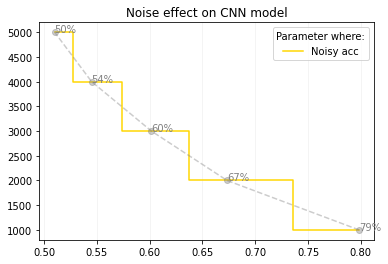

In [ ]:
test_effect(classes=['one','two','three'], c_model=model)

##Autoencoder Model

In [ ]:
def define_autoencoder(input_shape=(516, 36, 1)):
  """
  Define a convolutional autoencoder with the given input shape.

    Arguments:
    - input_shape: Tuple representing the shape of the input data.

    Returns:
    - autoencoder: A Keras model that represents the convolutional autoencoder.

    The autoencoder consists of the following layers:
    - An input layer with shape input_shape.
    - A convolutional layer with 16 filters, a 3x3 kernel, 'same' padding, and ReLU activation.
    - A max pooling layer with a 2x2 pool size and 'same' padding.
    - A convolutional layer with 8 filters, a 3x3 kernel, 'same' padding, and ReLU activation.
    - A max pooling layer with a 3x3 pool size and 'same' padding.
    - A convolutional layer with 8 filters, a 2x2 kernel, 'same' padding, and ReLU activation.
    - An upsampling layer with a 3x3 upsampling size.
    - A concatenation layer that combines the output of the previous convolutional layer and the previous max pooling layer along the channel axis.
    - A convolutional layer with 16 filters, a 3x3 kernel, 'same' padding, and ReLU activation.
    - An upsampling layer with a 2x2 upsampling size.
    - A concatenation layer that combines the output of the first convolutional layer and the previous upsampling layer along the channel axis.
    - A convolutional layer with 1 filter, a 3x3 kernel, 'same' padding, and hyperbolic tangent (tanh) activation.

    The autoencoder is compiled with the Adam optimizer and mean squared error loss.
  """
  input_img = tf.keras.layers.Input(shape=input_shape)

  conv11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img) #516
  conv1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv11) #258
  conv2 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(conv1) #258
  encoded = tf.keras.layers.MaxPooling2D((3, 3), padding='same')(conv2) #86

  bottelneck = tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding='same')(encoded) #86

  up1 = tf.keras.layers.UpSampling2D((3, 3))(bottelneck) #258
  merge1 = concatenate([conv2,up1], axis = 3) #258
  conv4 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(merge1) #258
  up2 = tf.keras.layers.UpSampling2D((2, 2))(conv4) #516
  merge2 = concatenate([conv11,up2], axis = 3) 
  decoded = tf.keras.layers.Conv2D(1, (3, 3), activation='tanh', padding='same')(merge2)


  autoencoder = tf.keras.models.Model(input_img, decoded)
  autoencoder.compile(optimizer='adam', loss='mean_squared_error') #remove it in the gan case
  
  return autoencoder

In [ ]:
autoencoder = define_autoencoder()
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 516, 36, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 516, 36, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 258, 18, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 258, 18, 8)   1160        ['max_pooling2d[0][0]']      

In [ ]:
def blender2(data, noisy):
  """
  This function takes two NumPy arrays data and noisy and returns shuffled versions of these arrays using a random permutation of their indices.

  data: NumPy array of shape (num_samples, ...), where num_samples is the number of data samples and ... represents the shape of each data sample.
  noisy: NumPy array of shape (num_samples, ...), where num_samples is the number of data samples and ... represents the shape of each noisy data sample.
  Returns:

  data: shuffled version of the data array.
  noisy: shuffled version of the noisy array.
  Note: This function shuffles the data and noisy arrays using the same permutation of indices so that the data and corresponding noisy data remain aligned.
  """
  idx = np.random.permutation(data.shape[0])
  return data[idx], noisy[idx]

def getData(data):
  """
  Function name: getData

  Description:
  This function takes in a data parameter, which is used to load data using the data_load function, with different parameters at different iterations of the for loop. The loaded data is then normalized and reshaped into a four-dimensional tensor. The function then uses the blender2 function to shuffle the noisy and clean data together and returns the resulting shuffled data as two four-dimensional numpy arrays.

  Arguments:

  data: A string parameter that specifies the type of data to be loaded.
  Returns:

  A tuple containing two four-dimensional numpy arrays, the shuffled clean data, and the shuffled noisy data.
  """
  d, noisy = [], []
  for i in [0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000]:
    _, x, _, n = data_load(data, 500, i)
    n = n / 255
    n = n.reshape(n.shape[0], n.shape[1], n.shape[2], 1).astype('float32')
    x = x / 255
    x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1).astype('float32')
    noisy.append(n)
    d.append(x)
  #return np.array(d).shape
  return blender2(np.array(d).reshape((13500, 516, 36, 1)), np.array(noisy).reshape((13500, 516, 36, 1)))

In [ ]:
def autoPreprocessing(classes):
  """
  Preprocesses the input data for use in an autoencoder model.

    Args:
        classes (str): The file path to the input data.

    Returns:
        Tuple: A tuple of four NumPy arrays: x_train_noisy, x_test_noisy, train_data, and test_data.
               The first two arrays (x_train_noisy and x_test_noisy) contain the noisy versions of the training and test data, respectively.
               The last two arrays (train_data and test_data) contain the clean versions of the training and test data, respectively.
  """
  x, noisy = getData(classes)
  train_data_noise, test_data_noise = np.split(noisy, [int(0.8 * len(noisy))])
  train_data, test_data = np.split(noisy, [int(0.8 * len(x))])

  x_train_noisy = train_data_noise.reshape(train_data_noise.shape[0], train_data_noise.shape[1], train_data_noise.shape[2], 1).astype('float32')
  x_test_noisy = test_data_noise.reshape(test_data_noise.shape[0], test_data_noise.shape[1], test_data_noise.shape[2], 1).astype('float32')

  train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1).astype('float32')
  test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1).astype('float32')
  return x_train_noisy, x_test_noisy, train_data, test_data

In [ ]:
#load noisy data
x_train_noisy, x_test_noisy, train_data, test_data = autoPreprocessing(['one', 'two', 'three'])

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !

500 of data is loaded !

1000 of data is loaded !

1500 of data is loaded !



In [ ]:
#train autoencoder
his = autoencoder.fit(train_data, x_train_noisy, epochs=100, batch_size=128, validation_data=(test_data, x_test_noisy))

Epoch 1/100
85/85 [==============================] - 19s 94ms/step - loss: 0.1104 - val_loss: 0.1027
Epoch 2/100
85/85 [==============================] - 7s 80ms/step - loss: 0.0980 - val_loss: 0.1012
Epoch 3/100
85/85 [==============================] - 7s 80ms/step - loss: 0.0973 - val_loss: 0.1009
Epoch 4/100
85/85 [==============================] - 7s 79ms/step - loss: 0.0971 - val_loss: 0.1007
Epoch 5/100
85/85 [==============================] - 7s 80ms/step - loss: 0.0969 - val_loss: 0.1006
Epoch 6/100
85/85 [==============================] - 7s 78ms/step - loss: 0.0969 - val_loss: 0.1006
Epoch 7/100
85/85 [==============================] - 7s 79ms/step - loss: 0.0968 - val_loss: 0.1006
Epoch 8/100
85/85 [==============================] - 7s 78ms/step - loss: 0.0968 - val_loss: 0.1005
Epoch 9/100
85/85 [==============================] - 7s 79ms/step - loss: 0.0968 - val_loss: 0.1005
Epoch 10/100
85/85 [==============================] - 7s 77ms/step - loss: 0.0968 - val_loss: 0.100

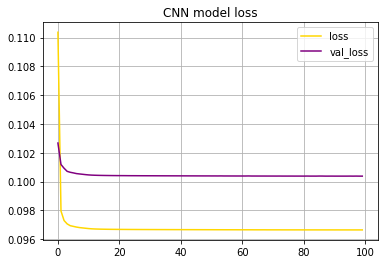

In [ ]:
plot_history_loss(his)

In [ ]:
save_model(autoencoder)

model saved under name: 'model.json' and 'model.h5'


200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 60ms/step - loss: 0.6905 - accuracy: 0.7883
succ of  1000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 62ms/step - loss: 2.0477 - accuracy: 0.4450
succ of  2000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 62ms/step - loss: 3.4853 - accuracy: 0.3400
succ of  3000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 61ms/step - loss: 4.3896 - accuracy: 0.3333
succ of  4000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 61ms/step - loss: 4.9965 - accuracy: 0.3333
succ of  5000


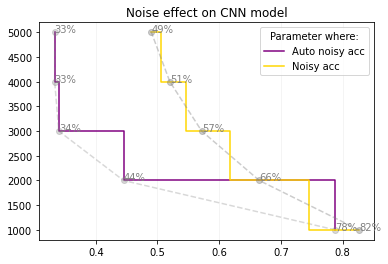

In [ ]:
test_effect(classes=['one', 'two', 'three'], c_model=cnn, g_model = autoencoder)

#GAN model

In [ ]:
def load_real_samples(classes):
  """
  Load real samples from the dataset.

  Parameters:
  - classes: a list of strings representing the classes to load samples from

  Returns:
  - X: a numpy array of shape (num_samples, height, width, 1) representing the original images
  - Y: a numpy array of shape (num_samples, height, width, 1) representing the noisy images
  """
  _, trainX, _, noisy = data_load(classes, 2000, 3000)
  X = expand_dims(trainX, axis=-1)
  Y = expand_dims(noisy, axis=-1)
  X = X.astype('float32')
  Y = Y.astype('float32')
  X = X / 255
  Y = Y / 255
  return X, Y

def load_real_samples2(classes):
  """
  Function Name: load_real_samples2

  Inputs:

  classes: a list of integers representing the classes to be loaded
  Outputs:

  X: numpy array of shape (n_samples, height, width, channels), where n_samples is the total number of samples, height and width are the dimensions of each image, and channels is 1.
  Y: numpy array of shape (n_samples, height, width, channels), where n_samples is the total number of samples, height and width are the dimensions of each image, and channels is 1.
  Functionality:
  This function loads the real samples and corresponding noisy samples from the specified classes.
  """
  trainX, noisy = [], []
  for i in [0, 1000, 2000, 3000]:
    print(f'With {i}Hz of noisy!')
    _, t, _, n = data_load(classes, 300, i)
    trainX.append(t)
    noisy.append(n)
  trainX, noisy = np.array(trainX), np.array(noisy)
  trainX, noisy = trainX.reshape(trainX.shape[1]*trainX.shape[0], trainX.shape[2], trainX.shape[3]), noisy.reshape(noisy.shape[1]*noisy.shape[0], noisy.shape[2], noisy.shape[3])
  trainX, noisy = blender2(trainX, noisy)
  X = expand_dims(trainX, axis=-1)
  Y = expand_dims(noisy, axis=-1)
  X = X.astype('float32')
  Y = Y.astype('float32')
  X = X / 255
  Y = Y / 255
  return X, Y

def generate_real_samples(dataset, n_samples):
  """
  Function Name: generate_real_samples

  Inputs:

  dataset: a numpy array containing the real samples
  n_samples: an integer representing the number of samples to generate
  Output:

  X: a numpy array of shape (n_samples, dataset.shape[1], dataset.shape[2], dataset.shape[3]) containing the real samples randomly selected from the dataset
  y: a numpy array of shape (n_samples, 1) containing all ones, representing the labels for the real samples
  Functionality: This function generates a random selection of real samples from a given dataset and returns the samples along with their corresponding labels
  """
  ix = randint(0, dataset.shape[0], n_samples)
  X = dataset[ix]
  y = ones((n_samples, 1))
  return X, y

def generate_noisy(noisy, n_samples):
  """
  Function Name: generate_noisy

  Input(s):

  noisy: A numpy array representing a dataset of noisy images.
  n_samples: An integer representing the number of noisy images to select.
  Output(s):

  X: A numpy array representing a subset of noisy containing n_samples randomly selected noisy images.
  Function Description: This function generates a subset of noisy by randomly selecting n_samples noisy images from the dataset. It first selects n_samples random indices within the range of indices in noisy, then returns the noisy images at those indices in a new numpy array X.
  """
  ix = randint(0, noisy.shape[0], n_samples)
  X = noisy[ix]
  return X

def generate_fake_samples(autoencoder, noisy, n_samples):
  """
  This function generates a batch of fake (i.e., denoised) samples using a given autoencoder model and a set of noisy samples.

  Arguments:

  autoencoder: A Keras model representing the autoencoder that will be used to denoise the noisy samples.
  noisy: A NumPy array containing the noisy input samples.
  n_samples: An integer specifying the number of fake (i.e., denoised) samples to generate.
  Returns:

  X: A NumPy array of shape (n_samples, height, width, channels) representing the fake (i.e., denoised) samples.
  y: A NumPy array of shape (n_samples, 1) containing all zeros, representing the fake (i.e., denoised) samples.
  """
  input_noisy = generate_noisy(noisy, n_samples)
  X = autoencoder.predict(input_noisy)
  y = zeros((n_samples, 1))
  return X, y

def save_plot(examples, epoch, n=10):
  """
  Description: This function is used to save a plot of generated images to file.

  Parameters:

  examples: NumPy array of generated images with shape (n_samples, height, width, channels) where n_samples is the number of generated images, height and width are the dimensions of each image, and channels is the number of color channels (e.g., 1 for grayscale, 3 for RGB).
  epoch: Integer representing the current epoch of training.
  n: Integer representing the number of rows and columns in the grid of generated images to be plotted. The total number of images plotted will be n*n.
  Returns: None.

  Notes:

  The generated plot will be saved to a file named generated_plot_e<epoch_number>.png, where <epoch_number> is the epoch number passed as the epoch parameter, zero-padded to 3 digits.
  The matplotlib.pyplot library is used to create and save the plot.
  The generated images are assumed to be in grayscale format and will be plotted with the 'gray_r' color map.
  """
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()
 
def define_discriminator(in_shape=(516,36,1)):
  """
  Function name: define_discriminator

  Input:

  in_shape: tuple specifying the shape of the input to the discriminator network. The default value is (516, 36, 1).
  Output:

  model: a Keras sequential model representing the discriminator network.
  Functionality:
  This function defines and compiles a convolutional neural network model for the discriminator.
  """
  model = Sequential()
  model.add(Conv2D(128, (5,2), strides=(2, 2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (5,2), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))
  model.add(Conv2D(32, (5,2), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.001, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

def define_autoencoder(input_shape=(516, 36, 1)):
  """
  Defines a convolutional autoencoder model.

    Parameters:
    input_shape (tuple): The shape of the input data. Default is (516, 36, 1).

    Returns:
    autoencoder (tf.keras.models.Model): The autoencoder model.
  """
  input_img = tf.keras.layers.Input(shape=input_shape)
  conv11 = tf.keras.layers.Conv2D(64, (5, 2), activation='relu', padding='same')(input_img) #516
  conv1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(conv11) #258
  conv2 = tf.keras.layers.Conv2D(32, (5, 2), activation='relu', padding='same')(conv1) #258
  encoded = tf.keras.layers.MaxPooling2D((3, 3), padding='same')(conv2) #86
  bottelneck = tf.keras.layers.Conv2D(16, (5, 2), activation='relu', padding='same')(encoded) #86
  up1 = tf.keras.layers.UpSampling2D((3, 3))(bottelneck) #258
  merge1 = concatenate([conv2,up1], axis = 3) #258
  conv4 = tf.keras.layers.Conv2D(32, (5, 2), activation='relu', padding='same')(merge1) #258
  up2 = tf.keras.layers.UpSampling2D((2, 2))(conv4) #516
  merge2 = concatenate([conv11,up2], axis = 3) 
  decoded = tf.keras.layers.Conv2D(1, (5, 2), activation='tanh', padding='same')(merge2)
  autoencoder = tf.keras.models.Model(input_img, decoded) 
  return autoencoder

def define_gan(autoencoder, d_model):
  """
    Defines and compiles a Generative Adversarial Network (GAN) using a given autoencoder and discriminator models.

    Parameters:
        autoencoder (tf.keras.models.Model): The pre-trained autoencoder model to use as the generator component of the GAN.
        d_model (tf.keras.models.Model): The pre-trained discriminator model to use as the discriminator component of the GAN.

    Returns:
        tf.keras.models.Model: The compiled GAN model.
  """
  d_model.trainable = False
  model = Sequential()
  model.add(autoencoder)
  model.add(d_model)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

def summarize_performance(epoch, autoencoder, d_model, dataset, noisy, n_samples=100):
  """
  This function is used to evaluate the performance of a generative adversarial network (GAN) model. It takes in several arguments:

  Arguments:
  epoch : integer scalar : denotes the epoch number of the GAN training process. This is used for saving the generated plot with a unique filename.
  autoencoder : instance of tf.keras.Model : the autoencoder part of the GAN model. This is used to generate fake samples from the noise input.
  d_model : instance of tf.keras.Model : the discriminator part of the GAN model. This is used to classify the generated fake samples and real samples from the dataset.
  dataset : tensor : input dataset for the GAN training process. This should be of the shape (n_samples, image_height, image_width, channels).
  noisy : tensor : input noise for the autoencoder of the GAN model. This should be of the shape (n_samples, image_height, image_width, channels).
  n_samples : integer scalar : number of samples to be generated and evaluated by the GAN model.
  Output:
  This function does not return any output. It prints the accuracy of the discriminator model on real and fake samples generated by the GAN model. It also saves the generated plot of fake samples and the autoencoder model with a unique filename based on the epoch number.
  """
  X_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(autoencoder, noisy, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  #save_plot(x_fake, epoch)
  #filename = 'generator_model_%03d.h5' % (epoch + 1)
  #autoencoder.save(filename)

def train(autoencoder, d_model, gan_model, dataset, noisy, n_epochs=100, n_batch=128):
  """
  Function Name: train

  Input:

  autoencoder: A Keras model instance representing an autoencoder model.
  d_model: A Keras model instance representing a discriminator model.
  gan_model: A Keras model instance representing a GAN model.
  dataset: A numpy array representing the original clean dataset.
  noisy: A numpy array representing the noisy dataset.
  n_epochs: An integer representing the number of epochs to train the GAN model. Default value is 100.
  n_batch: An integer representing the batch size. Default value is 128.
  Output: None

  Functionality:

  The train function is responsible for training the GAN model.
  It takes in an autoencoder, a discriminator, a GAN model, a clean dataset and a noisy dataset as input, and trains the GAN model for the specified number of epochs using the given batch size.
  The function starts by determining the number of batches per epoch, and half of the batch size, and then iterates over each epoch and batch to train the models.
  For each batch, the function generates a set of real and fake samples for training the discriminator, and generates a set of noisy samples for training the GAN model.
  The function then trains the discriminator model on the real and fake samples, and the GAN model on the noisy samples, using the train_on_batch method of the Keras model class.
  After each epoch, the summarize_performance function is called to evaluate the performance of the autoencoder and discriminator models on a set of test data, and to save the generated images and model weights.
  """
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(autoencoder, noisy, half_batch)
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
      d_loss, _ = d_model.train_on_batch(X, y)
      X_gan = generate_noisy(noisy, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
    if (i+1) % 10 == 0:
      summarize_performance(i, autoencoder, d_model, dataset, noisy)

In [ ]:
# create the discriminator
d_model = define_discriminator()
# create the generator
autoencoder = define_autoencoder()
# create the gan
gan_model = define_gan(autoencoder, d_model)
# load image data
dataset, noisy = load_real_samples2(['one','two','three'])
# train model
train(autoencoder, d_model, gan_model, dataset, noisy)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
2/2 [==============================] - 0s 20ms/step
>12, 2/28, d=0.309, g=1.364
2/2 [==============================] - 0s 21ms/step
>12, 3/28, d=0.306, g=2.294
2/2 [==============================] - 0s 20ms/step
>12, 4/28, d=0.268, g=1.726
2/2 [==============================] - 0s 20ms/step
>12, 5/28, d=0.288, g=2.124
2/2 [==============================] - 0s 20ms/step
>12, 6/28, d=0.359, g=1.212
2/2 [==============================] - 0s 20ms/step
>12, 7/28, d=0.399, g=2.607
2/2 [==============================] - 0s 20ms/step
>12, 8/28, d=0.389, g=1.308
2/2 [==============================] - 0s 20ms/step
>12, 9/28, d=0.434, g=2.054
2/2 [==============================] - 0s 20ms/step
>12, 10/28, d=0.263, g=2.964
2/2 [==============================] - 0s 20ms/step
>12, 11/28, d=0.428, g=1.204
2/2 [==============================] - 0s 20ms/step
>12, 12/28, d=0.378, g=1.832
2/2 [==============================] - 

In [ ]:
save_model(autoencoder)

model saved under name: 'model.json' and 'model.h5'


200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 63ms/step - loss: 0.7346 - accuracy: 0.7183
succ of  1000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 64ms/step - loss: 0.7901 - accuracy: 0.6650
succ of  2000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 64ms/step - loss: 0.8258 - accuracy: 0.6400
succ of  3000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 62ms/step - loss: 0.9064 - accuracy: 0.5700
succ of  4000
200 of data is loaded !

400 of data is loaded !

600 of data is loaded !

19/19 [==============================] - 1s 61ms/step - loss: 1.1061 - accuracy: 0.5183
succ of  5000


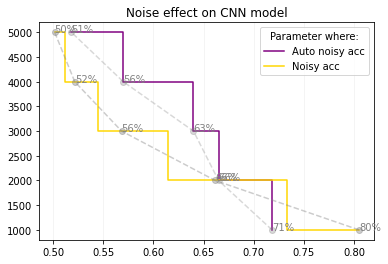

In [ ]:
test_effect(classes=['one', 'two', 'three'], c_model=cnn, g_model=autoencoder)

##Audio testing

In [ ]:
def prepareAudio(path):
  """
    Reads audio file from given path and applies various audio processing techniques.
    Returns the processed audio file and its sampling rate.
    
    Args:
    path (str): Path to the audio file to be processed.
    
    Returns:
    Tuple containing:
        - data (str): Processed audio file.
        - rate (int): Sampling rate of the processed audio file.
  """
  file_name, file_ext = os.path.splitext(path)
  if path.lower() != ".wav":
    from pydub import AudioSegment
    audio = AudioSegment.from_file(path, format=file_ext[1:]) # Load the MP4 audio file
    # Save the audio as a WAV file
    generatedFile = 'output.wav'
    audio.export(generatedFile, format='wav')
  else:
    generatedFile = path
  # Read the audio file
  sampling_rate, data = read(generatedFile)
  # Change the frequency by a factor of 2
  data = data[::2]
  # Write the modified audio to a new file
  write('output.wav', 16000, data)
  fs, audio = read('output.wav')
  for item in audio:
    if np.absolute(item) > 18000:
      n = audio[np.absolute(item): np.absolute(item) + 16000: 1]
      break
  rate = 1600
  write("output.wav", rate=16000, data=n)
  data = 'output.wav'
  return data, rate

In [ ]:
def audio_pridection(classes, spectro, cnn_model, autoecoder=None):
  """
  This function takes in a list of classes, a spectrogram, a CNN model, and an optional autoencoder, and returns a prediction of the class of the input audio.

    Parameters:
    classes (list): A list of strings representing the classes that the CNN model can predict.
    spectro (numpy array): A 2D numpy array representing the spectrogram of the input audio.
    cnn_model (tensorflow.keras.Model): A trained CNN model that can predict the class of the input audio.
    autoencoder (tensorflow.keras.Model or None, optional): An optional trained autoencoder model that can be used to preprocess the input spectrogram before passing it to the CNN model. Defaults to None.

    Returns:
    str: A string representing the predicted class of the input audio.
  
  The function first checks whether an autoencoder is specified and whether the input spectrogram needs to be passed through the autoencoder.
  If an autoencoder is not specified or the minimum value of the input spectrogram is less than or equal to 0.75, the input spectrogram is reshaped and passed directly to the CNN model for prediction.
  If an autoencoder is specified and the minimum value of the input spectrogram is greater than 0.75, the input spectrogram is first passed through the autoencoder and then the resulting output is passed to the CNN model for prediction.
  The function returns the predicted class of the input audio as a string.
  """
  if autoecoder == None or np.min(spectro.reshape(spectro.shape[0]*spectro.shape[1])) <= 0.75:
    spectro = spectro.reshape(1, spectro.shape[0], spectro.shape[1], 1)
    p = cnn.predict(spectro)
  else:
    p = cnn.predict(autoecoder.predict(spectro.reshape((1, spectro.shape[0], spectro.shape[1], 1))))
  n = np.where(p[0] == np.max(p[0]))
  return classes[n[0][0]]

In [ ]:
def set_models(cnnPathJson, cnnPathH5, autoencoderPathJson, autoencoderPathH5):
  """
  Function Signature:

    def set_models(cnnPathJson: str, cnnPathH5: str, autoencoderPathJson: str, autoencoderPathH5: str) -> Tuple[tf.keras.Model, tf.keras.Model]:
  Description:

    This function loads a Convolutional Neural Network (CNN) model and an Autoencoder model from JSON files and their respective weights from H5 files. The function compiles both models with the Adam optimizer and categorical cross-entropy loss function, and returns the two compiled models.
  Parameters:

    cnnPathJson - A string representing the file path of the JSON file containing the CNN model architecture.
    cnnPathH5 - A string representing the file path of the H5 file containing the CNN model weights.
    autoencoderPathJson - A string representing the file path of the JSON file containing the Autoencoder model architecture.
    autoencoderPathH5 - A string representing the file path of the H5 file containing the Autoencoder model weights.
  Returns:

    A tuple of two compiled Keras models: the CNN model and the Autoencoder model.
  Example:

    cnnPathJson = '/content/cnn_model.json'
    cnnPathH5 = '/content/cnn_model_weights.h5'
    autoencoderPathJson = '/content/autoencoder_model.json'
    autoencoderPathH5 = '/content/autoencoder_model_weights.h5'

    cnn_model, autoencoder_model = set_models(cnnPathJson, cnnPathH5, autoencoderPathJson, autoencoderPathH5)
  """
  #Reading the model from JSON file
  with open(cnnPathJson, 'r') as json_file:
      json_savedModel= json_file.read()
  #load the model architecture 
  cnn = tf.keras.models.model_from_json(json_savedModel)
  cnn.summary()
  cnn.load_weights(cnnPathH5)
  cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


  print('\n\n\n\n')
  print('---'*30)
  print('\n\n\n\n')

  
  #Reading the model from JSON file
  with open(autoencoderPathJson, 'r') as json_file:
      json_savedModel= json_file.read()
  #load the model architecture 
  autoencoder = tf.keras.models.model_from_json(json_savedModel)
  autoencoder.summary()
  autoencoder.load_weights(autoencoderPathH5)
  autoencoder.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
  return cnn, autoencoder

In [ ]:
help(set_models)

Help on function set_models in module __main__:

set_models(cnnPathJson, cnnPathH5, autoencoderPathJson, autoencoderPathH5)
    Function Signature:
    
      def set_models(cnnPathJson: str, cnnPathH5: str, autoencoderPathJson: str, autoencoderPathH5: str) -> Tuple[tf.keras.Model, tf.keras.Model]:
    Description:
    
      This function loads a Convolutional Neural Network (CNN) model and an Autoencoder model from JSON files and their respective weights from H5 files. The function compiles both models with the Adam optimizer and categorical cross-entropy loss function, and returns the two compiled models.
    Parameters:
    
      cnnPathJson - A string representing the file path of the JSON file containing the CNN model architecture.
      cnnPathH5 - A string representing the file path of the H5 file containing the CNN model weights.
      autoencoderPathJson - A string representing the file path of the JSON file containing the Autoencoder model architecture.
      autoencoderPat

In [ ]:
cnn, autoencoder = set_models("/content/CNN516_36.json", "/content/CNN_weights516_36.h5", "/content/GAN_AUTO.json", "/content/GAN_AUTO.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 516, 36, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 516, 36, 128)      1920      
                                                                 
 conv2d_1 (Conv2D)           (None, 516, 36, 128)      229504    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 258, 18, 128)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 258, 18, 64)       114752    
                                                                 
 conv2d_3 (Conv2D)           (None, 258, 18, 64)       57408     
                                                             

In [ ]:
Audio(data="/content/two.mp4", rate=1600)

In [ ]:
d, r = prepareAudio(path='/content/two.mp4')

In [ ]:
Audio(data=d, rate=r)

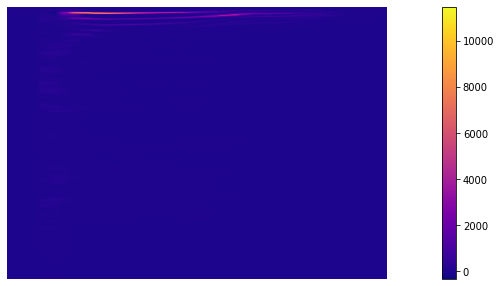

In [ ]:
fs, data = read(d)
audio = to_spictro(data, fs)
show_spectro(audio)

In [ ]:
noise = np.random.rand(audio.shape[0], audio.shape[1])
noisy = audio + noise * 3000

In [ ]:
without_noise = audio_pridection(classes=['one', 'two', 'three'], spectro=audio, cnn_model=cnn, autoecoder=autoencoder)

1/1 [==============================] - 0s 21ms/step


In [ ]:
without_noise

'two'

In [ ]:
withnoise = audio_pridection(classes=['one', 'two', 'three'], spectro=noisy, cnn_model=cnn, autoecoder=autoencoder)

1/1 [==============================] - 0s 31ms/step


In [ ]:
withnoise

'two'